[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lwieske/bloom-and-qlora/blob/main/bloom_3b_4bit_qlora_finetuning_with_dolly.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/lwieske/bloom-and-qlora/blob/main/bloom_3b_4bit_qlora_finetuning_with_dolly.ipynb)

# BLOOM 3B QLoRA 4bit Finetuning with Dolly Dataset

In [1]:
!pip -q install accelerate bitsandbytes datasets peft transformers trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 13.2 MB/s eta 0:00:00


In [2]:
import torch
import gc

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorForLanguageModeling, TrainingArguments
from trl import SFTTrainer
from peft import LoraConfig
from datasets import load_dataset

from matplotlib.pylab import plt

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [3]:
#MODEL      = "bigscience/bloom-560m"
#MODEL      = "bigscience/bloom-1b1"
#MODEL      = "bloom-1b7"
MODEL      = "bigscience/bloom-3b"
#MODEL      = "bigscience/bloom-7b1"

DATASET    = "databricks/databricks-dolly-15k"

TOKENS     = 20

EPOCHS     = 10

DEVICE_MAP = "auto"

BATCH_SIZE = 8

In [4]:
bnb_config = BitsAndBytesConfig(
                                    load_in_4bit=True,
                                    bnb_4bit_use_double_quant=True,
                                    bnb_4bit_quant_type="nf4",
                                    bnb_4bit_compute_dtype=torch.bfloat16
)

In [5]:
pretrained_model = AutoModelForCausalLM.from_pretrained(
                                                            MODEL,
                                                            quantization_config=bnb_config,
                                                            device_map=DEVICE_MAP,
                                                            use_cache=False
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.01G [00:00<?, ?B/s]

In [6]:
!nvidia-smi

Mon Dec  4 10:58:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |   3289MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

## Prepare Dataset

In [8]:
dataset = load_dataset(DATASET)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
def format_prompt(sample):
    instruction = f"### Instruction\n{sample['instruction']}"
    context = f"### Context\n{sample['context']}" if len(sample["context"]) > 0 else None
    response = f"### Answer\n{sample['response']}"
    prompt = "\n\n".join([i for i in [instruction, context, response] if i is not None])
    sample["prompt"] = prompt
    return sample

In [10]:
dataset = dataset.map(format_prompt)

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

In [11]:
dataset = dataset.remove_columns(['instruction', 'context', 'response', 'category'])

In [12]:
train_samples = dataset["train"].select(range(0,40))
eval_samples  = dataset["train"].select(range(40,50))

In [13]:
print(train_samples[:1])

{'prompt': ["### Instruction\nWhen did Virgin Australia start operating?\n\n### Context\nVirgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.\n\n### Answer\nVirgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route."]}


## Finetune BLOOM

In [14]:
lora_config = LoraConfig(
                            r=16,
                            lora_alpha=16,
                            target_modules=["query_key_value"],
                            lora_dropout=0.05,
                            bias="none",
                            task_type="CAUSAL_LM"
)

In [15]:
training_args = TrainingArguments(
                                    output_dir='./work',
                                    auto_find_batch_size=True,
                                    learning_rate=2e-4,
                                    num_train_epochs=EPOCHS,
                                    per_device_train_batch_size=BATCH_SIZE,
                                    per_device_eval_batch_size=BATCH_SIZE,
                                    logging_strategy="epoch",
                                    evaluation_strategy="epoch",
)

In [16]:
trainer = SFTTrainer(
                        model=pretrained_model,
                        args=training_args,
                        eval_dataset=eval_samples,
                        train_dataset=train_samples,
                        peft_config=lora_config,
                        dataset_text_field="prompt",
                        tokenizer=tokenizer,
                        max_seq_length=256,
                        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:247: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [17]:
trainer.train()

You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,2.749900,2.505706
2,2.453700,2.351375
3,2.197800,2.312591
4,2.089800,2.318103
5,2.061200,2.315568
6,1.969500,2.334358
7,1.914100,2.360816
8,1.827100,2.384735
9,1.823900,2.404668
10,1.759000,2.409641


TrainOutput(global_step=100, training_loss=2.0845944023132326, metrics={'train_runtime': 399.4261, 'train_samples_per_second': 1.001, 'train_steps_per_second': 0.25, 'total_flos': 1257975284981760.0, 'train_loss': 2.0845944023132326, 'epoch': 10.0})

In [18]:
log_history = trainer.state.log_history

In [19]:
training_losses   = [log["loss"]      for log in log_history if 'loss' in log.keys()]
validation_losses = [log["eval_loss"] for log in log_history if 'eval_loss' in log.keys()]
epochs            = [log["epoch"]     for log in log_history if 'loss' in log.keys()]

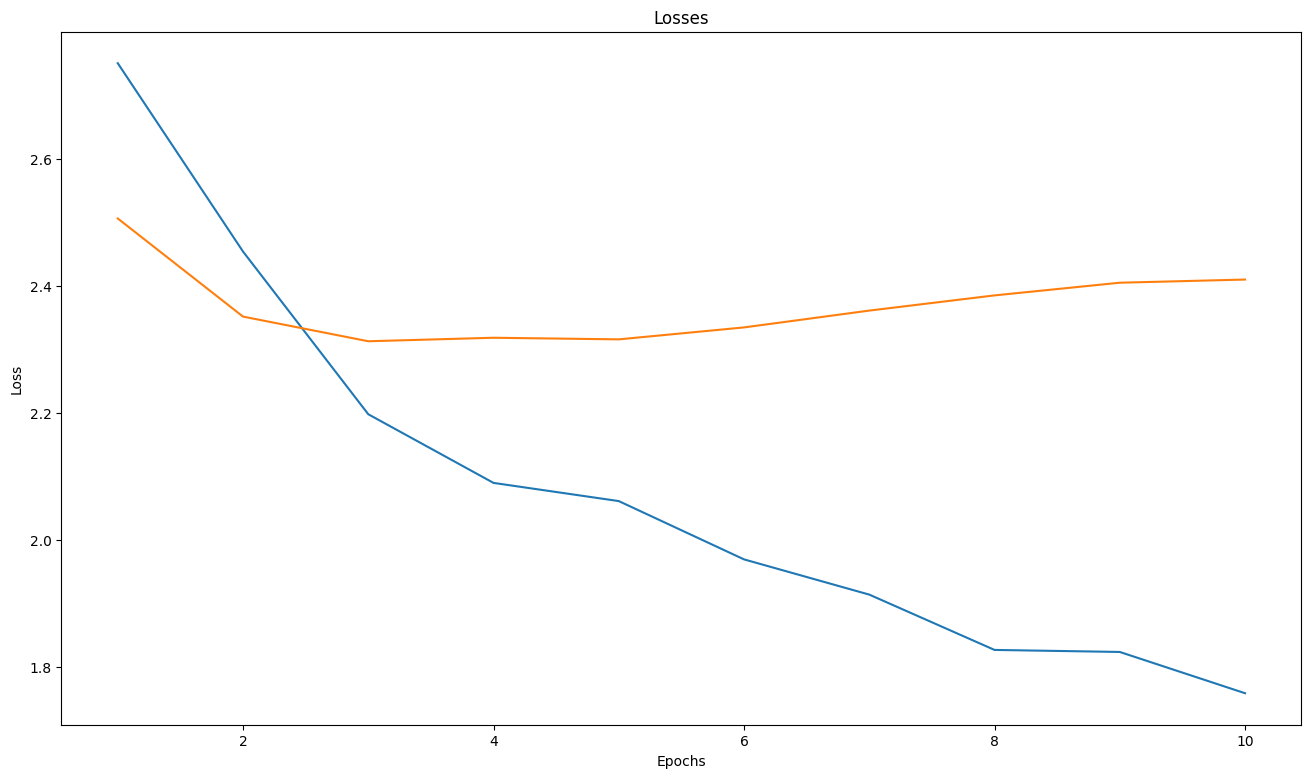

In [20]:
plt.rcParams['figure.figsize'] = (16,9)

fig, ax = plt.subplots(1)

ax.plot(epochs, training_losses,   label='Training Loss')
ax.plot(epochs, validation_losses, label='Validation Loss')

ax.set_title('Losses')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [21]:
!nvidia-smi

Mon Dec  4 11:05:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    42W /  70W |  14141MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
finetuned_model = trainer.model

In [23]:
del pretrained_model
del trainer
del train_samples
del eval_samples

torch.cuda.empty_cache()

gc.collect()

50

In [24]:
!nvidia-smi

Mon Dec  4 11:05:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    46W /  70W |   4783MiB / 15360MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Inference with Finetuned BLOOM

In [25]:
def generate_output_tokens(model, input_tokens):
    outputs = model.generate(
        input_ids=input_tokens["input_ids"],
        attention_mask=input_tokens["attention_mask"],
        max_new_tokens=TOKENS,
        repetition_penalty=1.5,
        early_stopping=False,
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

In [27]:
input_words = "What is the meaning of life?"

input_tokens = tokenizer(input_words, return_tensors="pt").to('cuda')

finetuned_output_tokens = generate_output_tokens(finetuned_model, input_tokens)

finetuned_output_words = tokenizer.batch_decode(finetuned_output_tokens, skip_special_tokens=True)

print(finetuned_output_words)

['What is the meaning of life? What does it mean to be human, what makes us unique and why do we exist?\nThe answer']
